## Simulating a surface code memory experiment

In [192]:
from typing import List, Tuple
from dataclasses import dataclass
from math import log10
import numpy as np
import matplotlib.pyplot as plt
import stim
import pymatching

# With `stim`

Let's do a transversal initialization, followed by phenomenological depolarizing noise, and then a single round of syndrome extraction. Decode with `PyMatching`, then get the logical error rate.

In [140]:
# See the stim tutorial!
def count_logical_errors(circuit: stim.Circuit, num_shots: int) -> int:
    # Sample the circuit.
    sampler = circuit.compile_detector_sampler()
    detection_events, observable_flips = sampler.sample(num_shots, separate_observables=True)

    # Configure a decoder using the circuit.
    detector_error_model = circuit.detector_error_model(decompose_errors=True)
    matcher = pymatching.Matching.from_detector_error_model(detector_error_model)

    # Run the decoder.
    predictions = matcher.decode_batch(detection_events)

    # Count the mistakes.
    num_errors = 0
    for shot in range(num_shots):
        actual_for_shot = observable_flips[shot]
        predicted_for_shot = predictions[shot]
        if not np.array_equal(actual_for_shot, predicted_for_shot):
            num_errors += 1
    return num_errors

stim.Circuit('''
    QUBIT_COORDS(0, 0) 0
    QUBIT_COORDS(1, 0) 1
    QUBIT_COORDS(2, 0) 2
    QUBIT_COORDS(3, 0) 3
    QUBIT_COORDS(4, 0) 4
    QUBIT_COORDS(0, 1) 5
    QUBIT_COORDS(1, 1) 6
    QUBIT_COORDS(2, 1) 7
    QUBIT_COORDS(3, 1) 8
    QUBIT_COORDS(4, 1) 9
    QUBIT_COORDS(0, 2) 10
    QUBIT_COORDS(1, 2) 11
    QUBIT_COORDS(2, 2) 12
    QUBIT_COORDS(3, 2) 13
    QUBIT_COORDS(4, 2) 14
    QUBIT_COORDS(0, 3) 15
    QUBIT_COORDS(1, 3) 16
    QUBIT_COORDS(2, 3) 17
    QUBIT_COORDS(3, 3) 18
    QUBIT_COORDS(4, 3) 19
    QUBIT_COORDS(0, 4) 20
    QUBIT_COORDS(1, 4) 21
    QUBIT_COORDS(2, 4) 22
    QUBIT_COORDS(3, 4) 23
    QUBIT_COORDS(4, 4) 24
    R 0 2 4 6 8 10 12 14 16 18 20 22 24 1 3 5 7 9 11 13 15 17 19 21 23
    TICK
    DEPOLARIZE1(0.1) 0 2 4 6 8 10 12 14 16 18 20 22 24
    H 1 3 11 13 21 23
    TICK
    CX 1 2 11 12 21 22 3 4 13 14 23 24 6 5 16 15 8 7 18 17
    TICK
    CX 1 6 11 16 3 8 13 18 10 5 20 15 12 7 22 17 14 9 24 19
    TICK
    CX 11 6 21 16 13 8 23 18 0 5 10 15 2

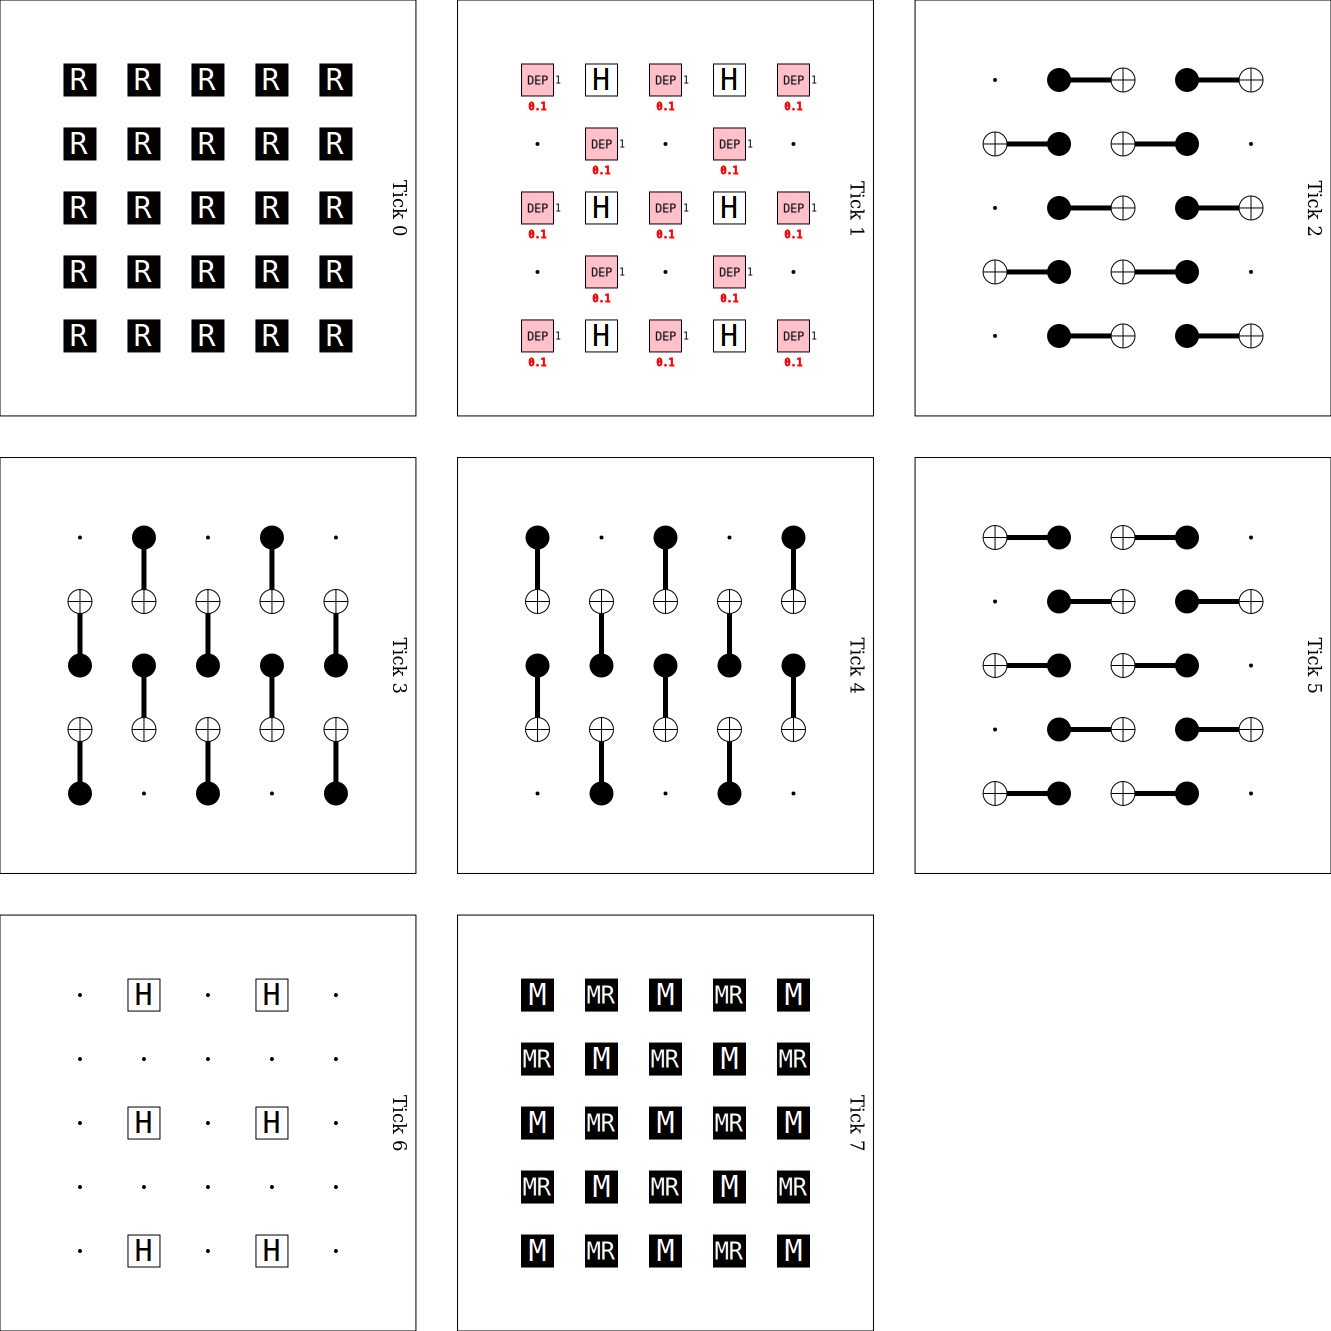

In [256]:
d = 3
noise = 0.1
circuit = stim.Circuit.generated(
    "surface_code:unrotated_memory_z",
    rounds=1, distance=d,
    before_round_data_depolarization=noise,
    before_measure_flip_probability=0.
)
print(repr(circuit))
circuit.diagram('timeslice-svg')

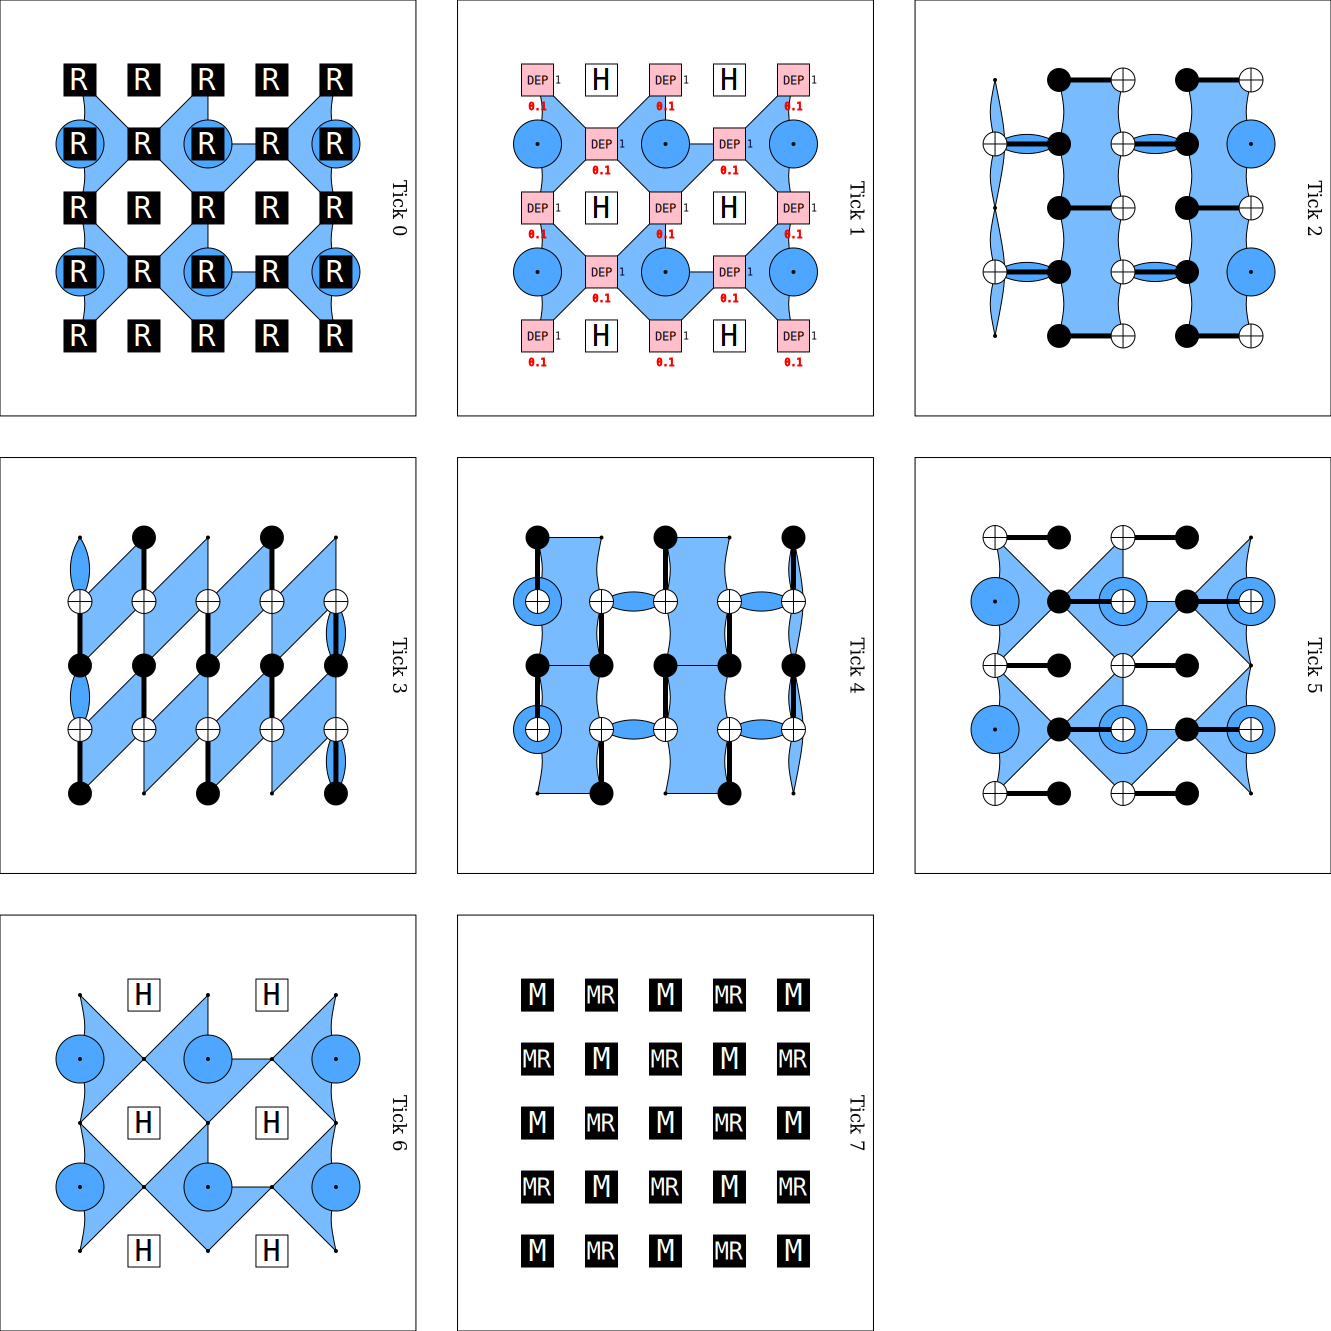

In [257]:
circuit.diagram('detslice-with-ops-svg')

In [142]:
dem = circuit.detector_error_model()
print(repr(dem))

stim.DetectorErrorModel('''
    error(0.0666667) D0 D1
    error(0.0666667) D0 D2
    error(0.0666667) D0 L0
    error(0.0666667) D1
    error(0.0666667) D1 D3
    error(0.0666667) D2 D3
    error(0.0666667) D2 D4
    error(0.0666667) D2 L0
    error(0.0666667) D3
    error(0.0666667) D3 D5
    error(0.0666667) D4 D5
    error(0.0666667) D4 L0
    error(0.0666667) D5
    detector(0, 1, 0) D0
    detector(0, 3, 0) D1
    detector(2, 1, 0) D2
    detector(2, 3, 0) D3
    detector(4, 1, 0) D4
    detector(4, 3, 0) D5
    detector(0, 1, 1) D6
    detector(0, 3, 1) D7
    detector(2, 1, 1) D8
    detector(2, 3, 1) D9
    detector(4, 1, 1) D10
    detector(4, 3, 1) D11
''')


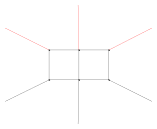

In [143]:
dem.diagram("matchgraph-svg")

In [144]:
shots = 100_000
ds = [3, 5, 7]
noise_rates = np.logspace(log10(0.125), log10(0.2), num=10)
lers = np.zeros((len(ds), len(noise_rates)), dtype=float)

for i, d in enumerate(ds):
    for j, noise in enumerate(noise_rates):
        circuit = stim.Circuit.generated(
            "surface_code:unrotated_memory_z",
            rounds=1, distance=d,
            before_round_data_depolarization=noise,
            before_measure_flip_probability=0.
        )
        num_errors = count_logical_errors(circuit, shots)
        ler = float(num_errors) / shots
        lers[i, j] = ler

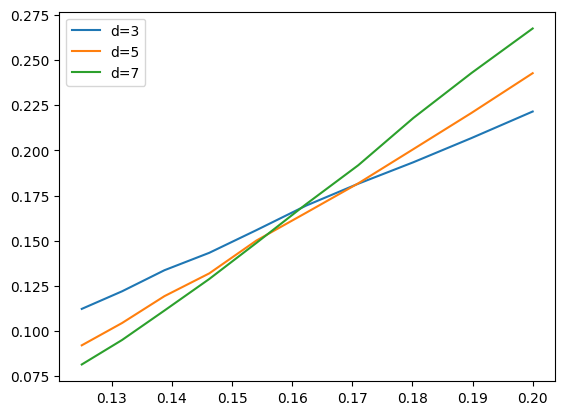

In [145]:
fig, ax = plt.subplots()
for i, d in enumerate(ds):
    ax.plot(noise_rates, lers[i, :], label=f"d={d}")
ax.legend()

# With my own circuit

In [146]:
def binary_np_array_to_str(arr: np.ndarray) -> str:
    """Convert a binary numpy array (one-dimensional) to a string,
    e.g. [True, False, True] -> '101'."""

    assert len(arr.shape) == 1
    return ''.join('1' if b else '0' for b in arr)

In [307]:
def z_measurement_gadget(measure_qubit: int, system_qubits: List[int]) -> stim.Circuit:
    """Get a circuit that measures an Z-type Pauli string."""

    ckt = stim.Circuit()
    ckt.append("R", measure_qubit)
    for sq in system_qubits:
        ckt.append("CX", [sq, measure_qubit])
    ckt.append("MR", measure_qubit)
    return ckt


def x_measurement_gadget(measure_qubit: int, system_qubits: List[int]) -> stim.Circuit:
    """Get a circuit that measures an X-type Pauli string."""

    ckt = stim.Circuit()
    ckt.append("R", measure_qubit)
    ckt.append("H", measure_qubit)
    for sq in system_qubits:
        ckt.append("CX", [measure_qubit, sq])
    ckt.append("H", measure_qubit)
    ckt.append("MR", measure_qubit)
    return ckt


@dataclass
class CodeStabilizer:
    """Representation of a stabilizer along with its measurement qubit."""

    type: str
    measure_qubit: int
    data_qubits: List[int]

    def __repr__(self) -> str:
        return f"{self.type}-type stabilizer with measure qubit {self.measure_qubit} and data qubits {self.data_qubits}."

    def to_circuit(self) -> stim.Circuit:
        """Build a measurement circuit for the stabilizer."""

        if self.type == "X":
            return x_measurement_gadget(self.measure_qubit, self.data_qubits)
        elif self.type == "Z":
            return z_measurement_gadget(self.measure_qubit, self.data_qubits)
        else:
            raise ValueError(f"Stabilizer has unknown type {self.type}.")


class SurfaceCode:

    def __init__(self, d: int):
        self._d = d
        self._z_stabilizers: List[CodeStabilizer] = []
        self._x_stabilizers: List[CodeStabilizer] = []

        qubits_per_side = 2 * d - 1
        for i in range(qubits_per_side):
            for j in range(qubits_per_side):
                qubit_idx = i * qubits_per_side + j
                if (i % 2 == 0 and j % 2 != 0) or (i % 2 != 0 and j % 2 == 0):
                    # This is a measurement qubit.
                    if i % 2 == 0 and j % 2 != 0:
                        stab_type = "Z"
                    else:
                        stab_type = "X"
                    # The data qubits are the nearest neighbors of this one.
                    data_qubits: List[int] = []
                    if i != 0:
                        # North qubit.
                        data_qubits.append((i - 1) * qubits_per_side + j)
                    if i != qubits_per_side - 1:
                        # South qubit.
                        data_qubits.append((i + 1) * qubits_per_side + j)
                    if j != 0:
                        # West qubit
                        data_qubits.append(i * qubits_per_side + j-1)
                    if j != qubits_per_side - 1:
                        # East qubit
                        data_qubits.append(i * qubits_per_side + j+1)
                    if stab_type == "Z":
                        self._z_stabilizers.append(CodeStabilizer(stab_type, qubit_idx, data_qubits))
                    else:
                        self._x_stabilizers.append(CodeStabilizer(stab_type, qubit_idx, data_qubits))
    
    @property
    def qubit_per_side(self) -> int:
        return 2 * self._d - 1

    @property
    def x_stabilizers(self) -> List[CodeStabilizer]:
        return self._x_stabilizers

    @property
    def z_stabilizers(self) -> List[CodeStabilizer]:
        return self._z_stabilizers

    def qubits(self, which: str="all") -> List[int]:
        """Get a list of all qubits in the code, data and measurement alike.
        
        Arguments:
        which - str that decides which qubits to get. Should be one of
        'data', 'measure', or 'all'."""

        assert which in ["all", "measure", "data"]

        qubit_list: List[int] = []
        for stabilizer in self._z_stabilizers + self._x_stabilizers:
            if which == "all" or which == "measure":
                qubit_list.append(stabilizer.measure_qubit)
            if which == "all" or which == "data":
                qubit_list += stabilizer.data_qubits
        return sorted(list(set(qubit_list)))
    
    @property
    def logical_x(self) -> stim.PauliString:
        """The logical X operator of the code. See Fowler Fig. 3."""

        qubits_per_side = 2 * self._d - 1
        qubit_coords = [(0, 2 * i) for i in range(self._d)]
        qubit_inds = [i * qubits_per_side + j for i, j in qubit_coords]
        pauli_spec = "+"
        for q in self.qubits("all"):
            if q in qubit_inds:
                pauli_spec += "X"
            else:
                pauli_spec += "_"
        return stim.PauliString(pauli_spec)

    @property
    def logical_z(self) -> stim.PauliString:
        """The logical Z operator of the code. See Fowler Fig. 3."""

        qubits_per_side = 2 * self._d - 1
        qubit_coords = [(2 * i, 0) for i in range(self._d)]
        qubit_inds = [i * qubits_per_side + j for i, j in qubit_coords]
        pauli_spec = "+"
        for q in self.qubits("all"):
            if q in qubit_inds:
                pauli_spec += "Z"
            else:
                pauli_spec += "_"
        return stim.PauliString(pauli_spec)
    
    @property
    def coords_circuit(self) -> stim.Circuit:
        """A circuit that assigns coordinates to the qubits for 2D visualization."""

        ckt = stim.Circuit()
        qubits_per_side = 2 * d - 1
        for i in range(qubits_per_side):
            for j in range(qubits_per_side):
                qubit_idx = i * qubits_per_side + j
                ckt.append_from_stim_program_text(f"QUBIT_COORDS({i},{j}) {qubit_idx}")
        return ckt
    
    def _qubit_index_to_coord(self, idx: int) -> Tuple[int, int]:
        """Convert an integer qubit index to (X, Y) coordinates."""

        qubits_per_side = 2 * self._d - 1
        i = (idx - (idx % qubits_per_side)) // qubits_per_side
        j = idx - i * qubits_per_side
        return (i, j)
    
    def _coord_to_qubit_index(self, i: int, j: int) -> Tuple[int, int]:
        qubits_per_side = 2 * self._d - 1
        return i * qubits_per_side + j

    @property
    def check_circuit(self) -> stim.Circuit:
        """A circuit that measures the stabilizers."""

        # check_ckt = stim.Circuit()
        # x_measure_qubits = []
        # for x_stab in self.x_stabilizers:
        #     x_measure_qubits.append(x_stab.measure_qubit)
        # check_ckt.append("H", x_measure_qubits)
        # check_ckt.append("TICK")
        # # Each stabilizer has three or four qubits, corresponding to CNOTs. Append the first cnot
        # # alongside the first CNOT for the others, then the second, ...
        # for i in range(4): # Index of the qubit in each stabilizer (might be at most 3 or 4.)
        #     cnot_qubits = [] # List of controls and targets for CNOT gates.
        #     for z_stab in self.z_stabilizers:
        #         if not (len(z_stab.data_qubits) == 3 and i == 3):
        #             cnot_qubits += [z_stab.data_qubits[i], z_stab.measure_qubit]
        #     for x_stab in self.x_stabilizers:
        #         if not (len(x_stab.data_qubits) == 3 and i == 3):
        #             cnot_qubits += [x_stab.measure_qubit, x_stab.data_qubits[i]]
        #     check_ckt.append("CNOT", cnot_qubits)
        #     check_ckt.append("TICK")
        # check_ckt.append("H", x_measure_qubits)
        # check_ckt.append("MR", self.qubits(which="measure"))
        # # Which measurements were Z? Add a detector there.
        # z_measure_qubits = sorted([stab.measure_qubit for stab in self.z_stabilizers])
        # z_measure_records = []
        # for i, qubit in enumerate(sorted(self.qubits(which="measure"))):
        #     if qubit in z_measure_qubits:
        #         z_measure_records.append(i)
        # for i in z_measure_records:
        #     check_ckt.append_from_stim_program_text(f"DETECTOR rec[{-1 - i}]")
        # check_ckt.append("TICK")
        # return check_ckt

        check_ckt = stim.Circuit()
        # Add hadamards for X stabilizers.
        x_measure_qubits = sorted([stab.measure_qubit for stab in self.x_stabilizers])
        z_measure_qubits = sorted([stab.measure_qubit for stab in self.z_stabilizers])
        check_ckt.append("H", x_measure_qubits)
        check_ckt.append("TICK")
        # Add the CNOT gates. These come in four rounds.
        # "North" data qubits
        cnot_qubits = []
        # for qubit in x_measure_qubits:
        #     i, j = self._qubit_index_to_coord(qubit)
        #     if i != 0:
        #         neighbor = self._coord_to_qubit_index(i-1, j)
        #         cnot_qubits += [qubit, neighbor]
        for qubit in z_measure_qubits:
            i, j = self._qubit_index_to_coord(qubit)
            if i != 0:
                neighbor = self._coord_to_qubit_index(i-1, j)
                cnot_qubits += [neighbor, qubit]
        check_ckt.append("CNOT", cnot_qubits)
        check_ckt.append("TICK")
        # "South" data qubits
        cnot_qubits = []
        # for qubit in x_measure_qubits:
        #     i, j = self._qubit_index_to_coord(qubit)
        #     if i != self.qubit_per_side - 1:
        #         neighbor = self._coord_to_qubit_index(i+1, j)
        #         cnot_qubits += [qubit, neighbor]
        for qubit in z_measure_qubits:
            i, j = self._qubit_index_to_coord(qubit)
            if i != self.qubit_per_side - 1:
                neighbor = self._coord_to_qubit_index(i+1, j)
                cnot_qubits += [neighbor, qubit]
        check_ckt.append("CNOT", cnot_qubits)
        check_ckt.append("TICK")
        # "East" data qubits
        cnot_qubits = []
        # for qubit in x_measure_qubits:
        #     i, j = self._qubit_index_to_coord(qubit)
        #     if j != self.qubit_per_side - 1:
        #         neighbor = self._coord_to_qubit_index(i, j+1)
        #         cnot_qubits += [qubit, neighbor]
        for qubit in z_measure_qubits:
            i, j = self._qubit_index_to_coord(qubit)
            if j != self.qubit_per_side - 1:
                neighbor = self._coord_to_qubit_index(i, j+1)
                cnot_qubits += [neighbor, qubit]
        check_ckt.append("CNOT", cnot_qubits)
        check_ckt.append("TICK")
        # "West" data qubits
        cnot_qubits = []
        # for qubit in x_measure_qubits:
        #     i, j = self._qubit_index_to_coord(qubit)
        #     if j != 0:
        #         neighbor = self._coord_to_qubit_index(i, j-1)
        #         cnot_qubits += [qubit, neighbor]
        for qubit in z_measure_qubits:
            i, j = self._qubit_index_to_coord(qubit)
            if j != 0:
                neighbor = self._coord_to_qubit_index(i, j-1)
                cnot_qubits += [neighbor, qubit]
        check_ckt.append("CNOT", cnot_qubits)
        check_ckt.append("TICK")
        # Add hadamards for X stabilizers.
        check_ckt.append("H", x_measure_qubits)
        check_ckt.append("TICK")
        # Measure all syndrome qubits and add detectors for Z errors.
        check_ckt.append("MR", self.qubits(which="measure"))
        z_measure_records = []
        for i, qubit in enumerate(sorted(self.qubits(which="measure"))):
            if qubit in z_measure_qubits:
                z_measure_records.append(i)
        num_measurements = len(self.qubits(which="measure"))
        for i in z_measure_records:
            check_ckt.append_from_stim_program_text(f"DETECTOR rec[{-num_measurements + i}]")
        check_ckt.append("TICK")
        return check_ckt

In [308]:
def surface_memory_circuit(d: int, p_depol: float, state_to_prepare: str = "0") -> stim.Circuit:
    """A circuit that prepares a logical states, subjects the data qubits to noise,
    then measures all the syndromes. The DEM asserts that the syndrome bits should match
    between the measurements from the state preparation step and the measurements from the
    error detection step. Then logical Z is measured."""

    assert state_to_prepare in ["0", "+"]
    assert 0. <= p_depol <= 1.
    assert d >= 3

    code = SurfaceCode(d)
    ckt = stim.Circuit()
    ckt += code.coords_circuit
    for qubit in code.qubits("all"):
        ckt.append("R", qubit)
        if state_to_prepare == '+':
            ckt.append("H", qubit)
    ckt.append("TICK")
    # Subject the data qubits to noise.
    ckt.append("DEPOLARIZE1", code.qubits("data"), arg=p_depol)
    ckt.append("TICK")
    # Measure again to get the error syndrome.
    ckt += code.check_circuit
    z_bar = code.logical_z
    measure_text = '*'.join(['Z' + str(idx) for idx in z_bar.pauli_indices()])
    ckt.append_from_stim_program_text(f"MPP {measure_text}")
    ckt.append_from_stim_program_text("OBSERVABLE_INCLUDE(0) rec[-1]")
    return ckt

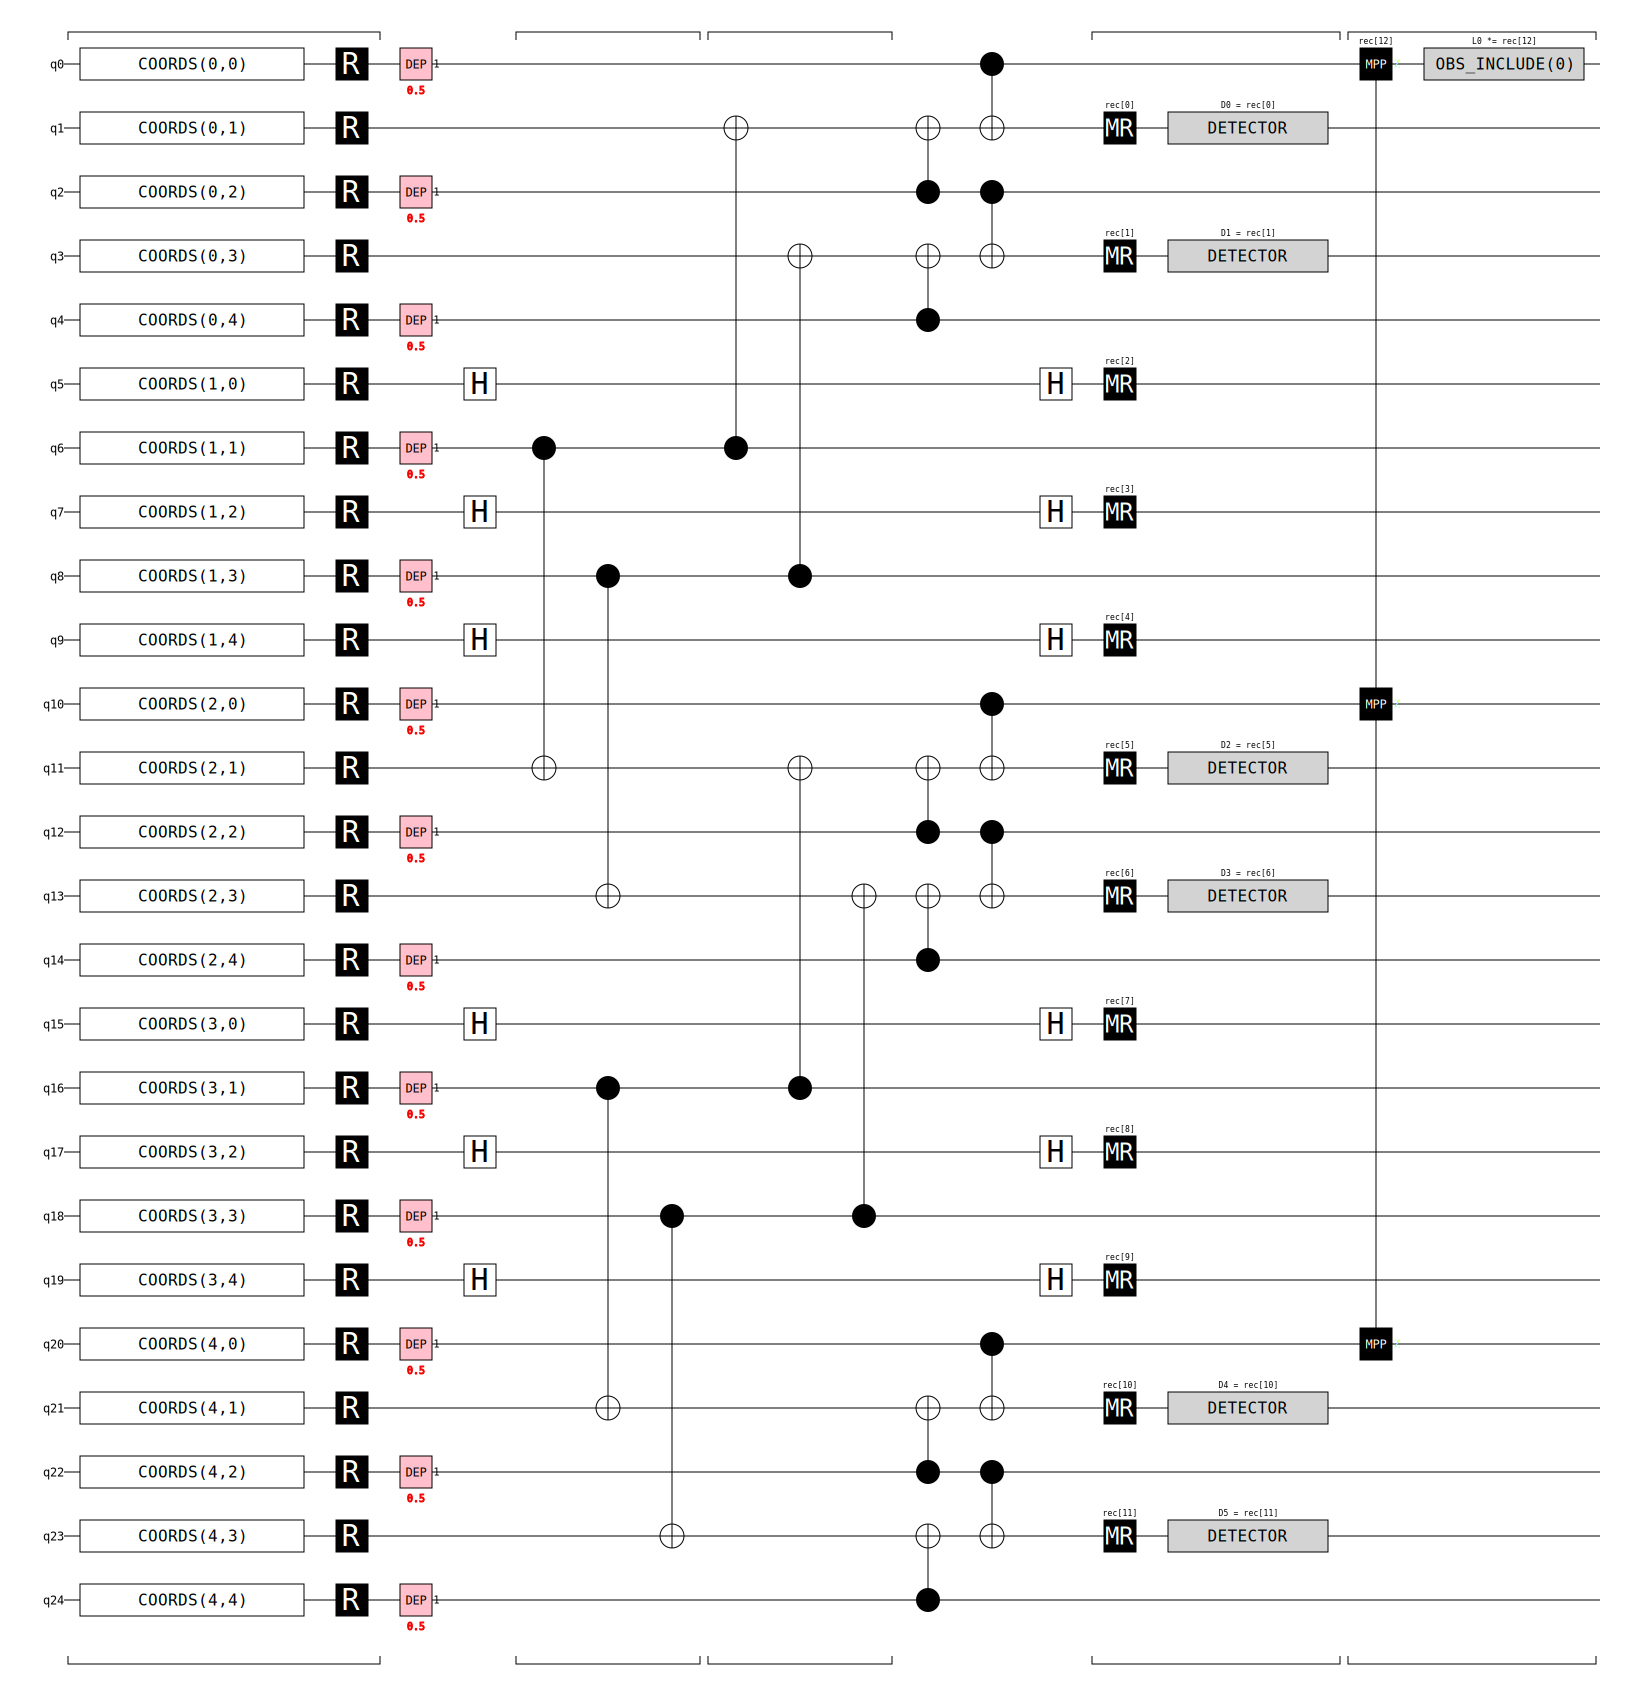

In [309]:
memory_ckt = surface_memory_circuit(3, 0.5)
memory_ckt.diagram('timeline-svg')

In [310]:
sampler = memory_ckt.compile_detector_sampler()
num_true = 0
shots = 100
syndromes_detectors, observables = sampler.sample(shots, separate_observables=True)
for syndrome, obs in zip(syndromes_detectors, observables):
    if obs[0]:
        num_true += 1
    print(binary_np_array_to_str(syndrome), binary_np_array_to_str(obs))
print(f"{num_true}/{shots} Z measurements were True.")

100110 1
011100 0
010111 0
100111 0
001110 1
110001 1
100110 1
000101 0
010001 0
001011 1
000001 0
001100 1
100011 0
001110 1
001000 0
000011 1
011110 1
010010 1
011101 1
111000 0
111000 1
010001 0
110010 1
000101 1
110000 1
000001 0
000011 1
111001 0
100111 1
001100 1
110010 0
001010 1
001111 0
000101 1
100011 0
100010 0
011101 1
001111 1
011000 1
110110 0
000000 1
000111 0
101011 1
010110 0
000011 0
011001 0
000100 1
011100 0
101100 0
011010 1
100011 0
100011 1
000001 0
001011 0
011110 1
110001 1
011110 1
111100 1
001010 1
101010 0
000010 1
011110 1
101000 0
010111 1
011001 1
111000 1
101001 1
001011 0
101110 0
001011 1
100010 0
100000 1
111000 0
101011 0
111000 1
100111 1
010111 1
100110 0
010101 0
010000 0
011000 0
000111 1
110110 0
100100 1
011000 1
011111 0
111100 1
101110 1
000111 1
110110 1
010010 1
011100 1
000100 0
000110 0
001101 0
010111 0
001001 0
001001 1
000100 1
001000 1
56/100 Z measurements were True.


In [311]:
print(repr(memory_ckt))

stim.Circuit('''
    QUBIT_COORDS(0, 0) 0
    QUBIT_COORDS(0, 1) 1
    QUBIT_COORDS(0, 2) 2
    QUBIT_COORDS(0, 3) 3
    QUBIT_COORDS(0, 4) 4
    QUBIT_COORDS(1, 0) 5
    QUBIT_COORDS(1, 1) 6
    QUBIT_COORDS(1, 2) 7
    QUBIT_COORDS(1, 3) 8
    QUBIT_COORDS(1, 4) 9
    QUBIT_COORDS(2, 0) 10
    QUBIT_COORDS(2, 1) 11
    QUBIT_COORDS(2, 2) 12
    QUBIT_COORDS(2, 3) 13
    QUBIT_COORDS(2, 4) 14
    QUBIT_COORDS(3, 0) 15
    QUBIT_COORDS(3, 1) 16
    QUBIT_COORDS(3, 2) 17
    QUBIT_COORDS(3, 3) 18
    QUBIT_COORDS(3, 4) 19
    QUBIT_COORDS(4, 0) 20
    QUBIT_COORDS(4, 1) 21
    QUBIT_COORDS(4, 2) 22
    QUBIT_COORDS(4, 3) 23
    QUBIT_COORDS(4, 4) 24
    R 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
    TICK
    DEPOLARIZE1(0.5) 0 2 4 6 8 10 12 14 16 18 20 22 24
    TICK
    H 5 7 9 15 17 19
    TICK
    CX 6 11 8 13 16 21 18 23
    TICK
    CX 6 1 8 3 16 11 18 13
    TICK
    CX 2 1 4 3 12 11 14 13 22 21 24 23
    TICK
    CX 0 1 2 3 10 11 12 13 20 21 22 23
    TICK

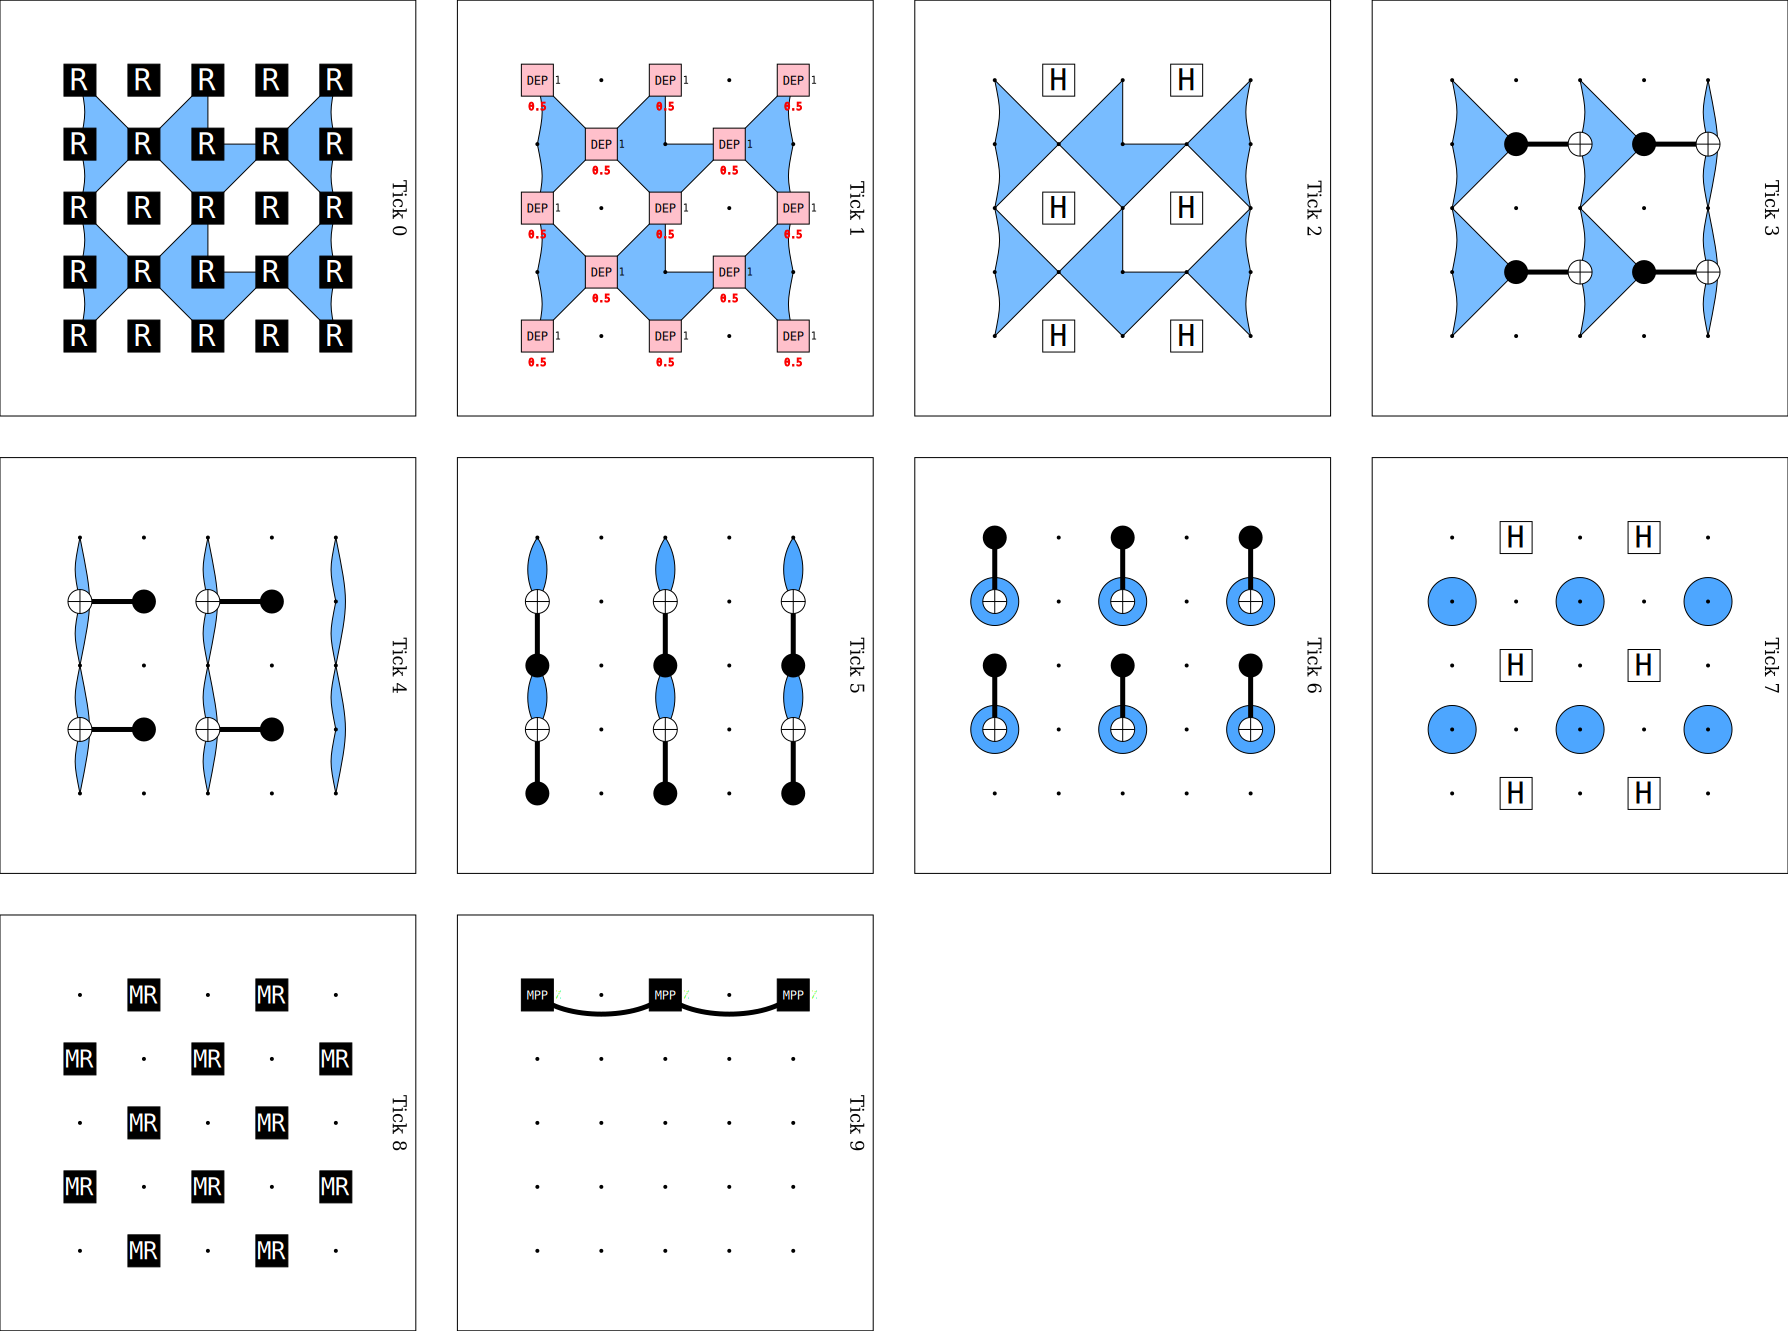

In [312]:
memory_ckt.diagram('detslice-with-ops-svg')

In [313]:
dem = memory_ckt.detector_error_model()
print(repr(dem))

stim.DetectorErrorModel('''
    error(0.333333) D0 D1
    error(0.333333) D0 D2
    error(0.333333) D0 L0
    error(0.333333) D1
    error(0.333333) D1 D3
    error(0.333333) D2 D3
    error(0.333333) D2 D4
    error(0.333333) D2 L0
    error(0.333333) D3
    error(0.333333) D3 D5
    error(0.333333) D4 D5
    error(0.333333) D4 L0
    error(0.333333) D5
''')


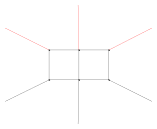

In [182]:
dem.diagram("matchgraph-svg")

In [163]:
shots = 10_000
num_errs = count_logical_errors(memory_ckt, shots)
print(f"Got {num_errs} logical errors out of {shots} shots.")

ValueError: The circuit contains non-deterministic detectors.

To make an SVG picture of the problem, you can use the python API like this:
    your_circuit.diagram('detslice-with-ops-svg', tick=range(0, 5), filter_coords=['D0', ])
or the command line API like this:
    stim diagram --in your_circuit_file.stim --type detslice-with-ops-svg --tick 0:5 --filter_coords D0 > output_image.svg

This was discovered while analyzing a Z-basis reset (R) on:
    qubit 24 [coords (4, 4)]

The collapse anti-commuted with these detectors/observables:
    D0

The backward-propagating error sensitivity for D0 was:
    X13 [coords (2, 3)]
    X14 [coords (2, 4)]
    X18 [coords (3, 3)]
    Z19 [coords (3, 4)]
    X23 [coords (4, 3)]
    X24 [coords (4, 4)]

Circuit stack trace:
    during TICK layer #1 of 7
    at instruction #26 [which is R 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]

In [ ]:
shots = 10_000
noise_rates = np.logspace(log10(0.125), log10(0.2), num=10)
ds = [3, 5, 7]
all_lers = np.zeros((len(ds), len(noise_rates)), dtype=float)
for i, d in enumerate(ds):
    for j, noise in enumerate(noise_rates):
        memory_ckt = surface_memory_circuit(d, noise)
        num_errors = count_logical_errors(memory_ckt, shots)
        ler = float(num_errs) / float(shots)
        all_lers[i, j] = ler

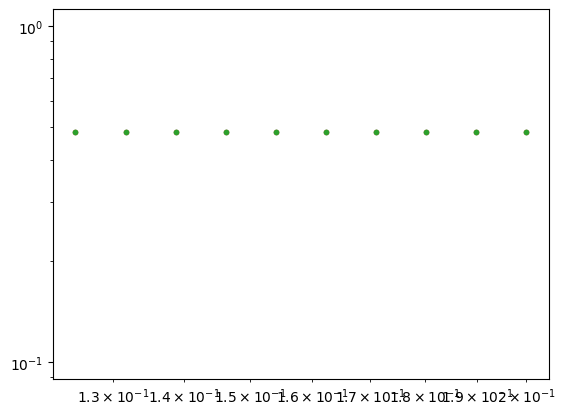

In [ ]:
fig, ax = plt.subplots()
ax.plot(noise_rates, all_lers.T, '.')
ax.set_yscale("log")
ax.set_xscale("log")